In [1]:
import os
import numpy as np
from scipy import fftpack
from scipy import linalg
import h5py
import pywt
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'turbo'
np.random.seed(1111)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Activation

In [3]:
with h5py.File('/Users/harshitlakum/Desktop/DECals_galaxies.hdf5') as F:
    images = np.array( F['images_spirals'] )

In [4]:
# Calculate the average over the last axis (channels)
average_dataset = np.mean(images, axis=-1)

# Select the 25th image from the averaged dataset
X_orig = average_dataset[25]



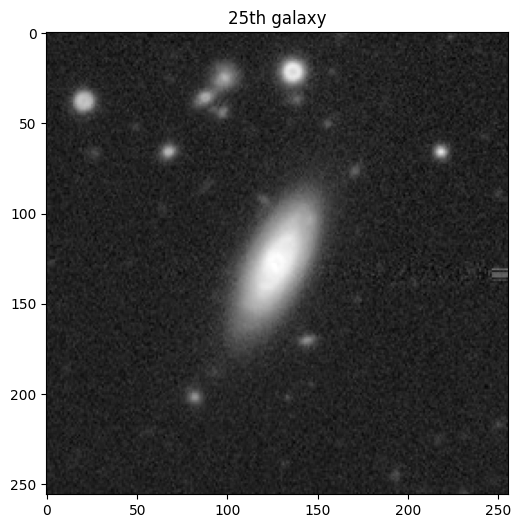

In [5]:
# Plot the galaxy image
plt.figure(figsize=(6, 6))
plt.imshow(X_orig, cmap='gray')
plt.title('25th galaxy')
plt.show()

In [6]:
# Store the shape (2D and flattened as 1D)
shape = X_orig.shape
print(shape)
D = np.prod(shape)


(256, 256)


In [7]:
# Print the minimum and maximum pixels values
print(X_orig.min(), X_orig.max())

1.0 233.66666666666666


In [8]:
# Generate Gaussian noise
mean = 0  # mean of the Gaussian noise
std_dev = 10  # standard deviation of the Gaussian noise
gaussian_noise = np.random.normal(mean, std_dev, X_orig.shape)


X_noisy_raw = X_orig + gaussian_noise


In [9]:
def clip_vals(x, low = 0, high = 255):
    clipped_data = np.clip(x, low, high)
    return clipped_data

    

In [10]:
X_noisy = clip_vals(X_noisy_raw)


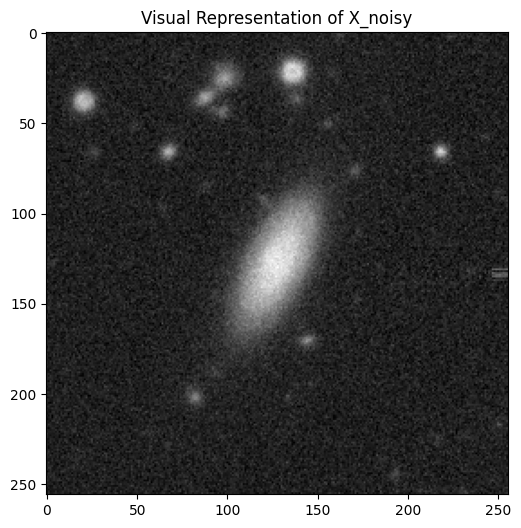

In [11]:

# Plotting the image
plt.figure(figsize=(6, 6))
plt.imshow(X_noisy, cmap='gray')  # Use a grayscale colormap and set the color range
plt.title('Visual Representation of X_noisy')
plt.show()

In [12]:
# Generate subsampled picture Y
 # X_noisy is already defined and contains the noisy image data
probability_of_keeping = 0.5  # 5% chance of keeping a pixel



mask = np.random.rand(*X_noisy.shape) < probability_of_keeping
Y =  np.where(mask, X_noisy, 0)

print("X noisy pixels:", X_noisy.size)
print("Y noisy pixels:", Y.size)

X noisy pixels: 65536
Y noisy pixels: 65536


In [13]:
probability_of_keeping = 0.2  # 5% chance of keeping a pixel



mask = np.random.rand(*X_noisy.shape) < probability_of_keeping
Z =  np.where(mask, X_noisy, 0)

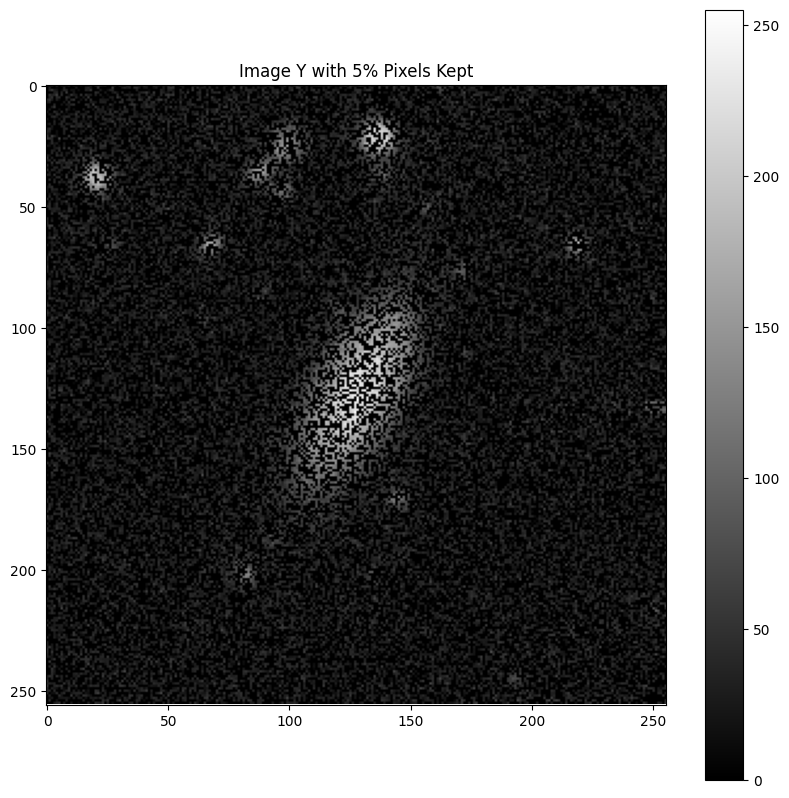

In [14]:
# Plot of the subsampled image
# Display the result using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(Y, cmap='gray')
plt.title('Image Y with 5% Pixels Kept')
plt.colorbar()
plt.show()

In [15]:
#let's normalize
print(X_orig)
print(X_orig.shape)

[[35.66666667 30.         27.         ... 33.         32.33333333
  39.33333333]
 [23.33333333 43.33333333 19.33333333 ... 25.33333333 30.66666667
  26.        ]
 [24.66666667 37.         39.66666667 ... 27.33333333 31.
  21.66666667]
 ...
 [12.         22.66666667 27.33333333 ... 49.         39.33333333
  32.33333333]
 [19.66666667 36.66666667 37.33333333 ... 39.66666667 23.66666667
  26.        ]
 [21.         35.66666667 36.33333333 ... 33.         24.66666667
  29.33333333]]
(256, 256)


In [16]:
print(Y)
print(Y.shape)

[[22.66656352  0.         34.90199194 ...  0.          0.
  41.65699125]
 [ 0.         28.32004868  0.         ...  0.          8.75250047
  23.9704714 ]
 [ 0.         35.58772435 56.55107524 ...  0.          0.
   0.        ]
 ...
 [ 0.         16.16943687 27.96965918 ...  0.          0.
   0.        ]
 [ 0.         44.72274582  0.         ...  0.          0.
  37.35794624]
 [ 0.          0.          0.         ... 28.86297118  0.
  51.70771635]]
(256, 256)


Normalised

In [17]:
Clean_image = X_orig / 255.0
noisy_image = Y / np.max(Y)
Nnoisy_image = Z / np.max(Z)

In [18]:
Real = Clean_image[:, :, np.newaxis]
Noisy = noisy_image [:, :, np.newaxis]
Nnoisy_image = Nnoisy_image [:, :, np.newaxis]
print(Nnoisy_image.shape)
lys = Nnoisy_image.reshape((1, 256, 256, 1))



(256, 256, 1)


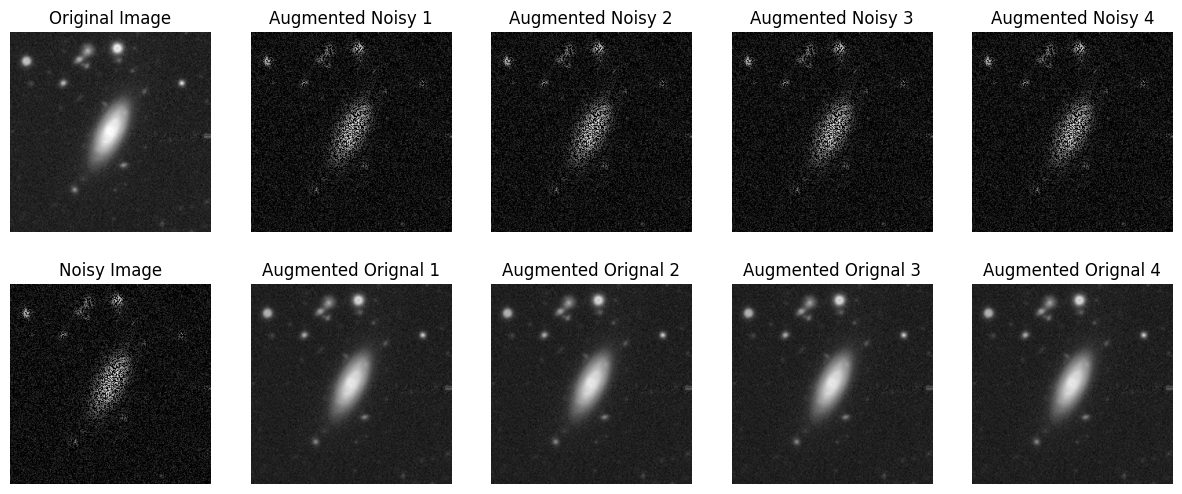

In [19]:

def image_augmentation_generator(original_images, noisy_images, batch_size=1, num_samples= 4):
    
    
    # Reshape images to match the expected input shape of the generator
    original_images_reshaped = original_images.reshape((1, 256, 256, 1))
    noisy_images_reshaped = noisy_images.reshape((1, 256, 256, 1))
    
    # Setup your image data generator with specific seed to ensure the same transformations
    datagen = ImageDataGenerator(
        rotation_range=0.00,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    
    for _ in range(num_samples):
        # Use the same seed for both calls to ensure the same transformation is applied
        seed = np.random.randint(100)  # Generate a random seed
        aug_iter_original = datagen.flow(original_images_reshaped, batch_size=batch_size, seed=seed)
        aug_iter_noisy = datagen.flow(noisy_images_reshaped, batch_size=batch_size, seed=seed)
        
        aug_original = next(aug_iter_original)
        aug_noisy = next(aug_iter_noisy)
        
        yield (next(aug_iter_noisy), next(aug_iter_original)) 


# Ensure image is normalized if necessary
original_image_normalized = X_orig / 255.0
noisy_image_normalized = Y / 255.0

original_images = original_image_normalized.reshape((1, 256, 256, 1)) # This needs to be your actual data
noisy_images = noisy_image_normalized.reshape((1, 256, 256, 1))


batch_size = 1
num_samples = 4

# Initialize the generator
generator = image_augmentation_generator(original_images, noisy_images, batch_size, num_samples)
# Test generator output
test_gen = image_augmentation_generator(original_images, noisy_images, 1, 4)
for _ in range(2):  # Pull a couple of samples to see output
    next(test_gen)

# Display augmented images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs[0, 0].imshow(original_images[0, :, :], cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')
axs[1, 0].imshow(noisy_images[0, :, :], cmap='gray')
axs[1, 0].set_title('Noisy Image')
axs[1, 0].axis('off')

for i, (aug_original, aug_noisy) in enumerate(generator):
    if i < num_samples:
        axs[0, i+1].imshow(aug_original[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
        axs[0, i+1].set_title(f'Augmented Noisy {i+1}')
        axs[0, i+1].axis('off')
        axs[1, i+1].imshow(aug_noisy[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
        axs[1, i+1].set_title(f'Augmented Orignal {i+1}')
        axs[1, i+1].axis('off')

plt.show()


In [20]:


def conv2d_block(input_tensor, n_filters, kernel_size=1, batch_norm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(256, 256, 1), n_filters=64, n_classes=1):
    inputs = Input(input_size)

    # Contracting Path
    c1 = conv2d_block(inputs, n_filters=n_filters*1, kernel_size=1, batch_norm=True)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(0.1)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=1, batch_norm=True)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(0.1)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=1, batch_norm=True)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(0.2)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=1, batch_norm=True)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = tf.keras.layers.Dropout(0.2)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=1, batch_norm=True)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    u6 = tf.keras.layers.Dropout(0.2)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=1, batch_norm=True)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    u7 = tf.keras.layers.Dropout(0.2)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=1, batch_norm=True)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    u8 = tf.keras.layers.Dropout(0.1)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=1, batch_norm=True)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    u9 = tf.keras.layers.Dropout(0.1)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=1, batch_norm=True)

    # Output Layer
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)  # Use sigmoid for binary output

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      4,160 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      8,320 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     16,512 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 9,434,945 (35.99 MB)

 Trainable params: 9,423,169 (35.95 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [50]:
def image_augmentation_generator(original_images, noisy_images, batch_size=1, num_samples= 4):
    
    
    # Reshape images to match the expected input shape of the generator
    original_images_reshaped = original_images.reshape((1, 256, 256, 1))
    noisy_images_reshaped = noisy_images.reshape((1, 256, 256, 1))
    
    # Setup your image data generator with specific seed to ensure the same transformations
    datagen = ImageDataGenerator(
        rotation_range=0.000,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    
    for _ in range(num_samples):
        # Use the same seed for both calls to ensure the same transformation is applied
        seed = np.random.randint(100)  # Generate a random seed
        aug_iter_original = datagen.flow(original_images_reshaped, batch_size=batch_size, seed=seed)
        aug_iter_noisy = datagen.flow(noisy_images_reshaped, batch_size=batch_size, seed=seed)
        
        aug_original = next(aug_iter_original)
        aug_noisy = next(aug_iter_noisy)
        
        yield (next(aug_iter_noisy), next(aug_iter_original)) 


# Ensure image is normalized if necessary
original_image_normalized = X_orig / 255.0
noisy_image_normalized = Y / 255.0

original_images = original_image_normalized.reshape((1, 256, 256, 1)) # This needs to be your actual data
noisy_images = noisy_image_normalized.reshape((1, 256, 256, 1))


batch_size = 1
num_samples = 4

# Initialize the generator
generator = image_augmentation_generator(original_images, noisy_images, batch_size, num_samples)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

model.fit(aug_noisy, aug_original, batch_size=3, epochs=2)


predicted_imgs = model.predict(lys)



Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.0116 - mean_squared_error: 0.0116
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


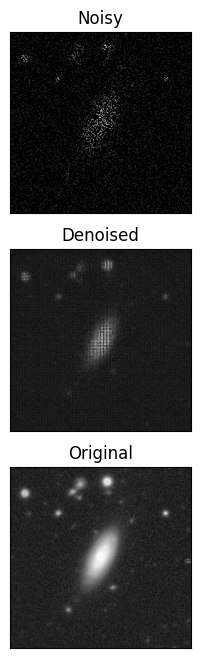

(1, 256, 256, 1)


In [52]:

def plot_examples(noisy_imgs, predicted_imgs, original_imgs, n=10):
    # Determine the number of images available in the dataset
    num_images = noisy_imgs.shape[0]
    n = min(n, num_images)  # Adjust n to be the maximum number of images available
    
    plt.figure(figsize=(8, 8))
    for i in range(n):
        # Plot Noisy Image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i].reshape(256, 256), cmap='gray')
        plt.title("Noisy")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot Predicted (Denoised) Image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(predicted_imgs[i].reshape(256, 256), cmap='gray')
        plt.title("Denoised")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot Original Image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(original_imgs[i].reshape(256, 256), cmap='gray')
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Assuming 'model' is your trained model and 'noisy_images', 'original_images' are available
        



    plt.show()
    
    
# Assuming 'model' is your trained model and 'noisy_images', 'original_images' are available
predicted_images = model.predict(noisy_images)
plot_examples(lys, predicted_images, original_images, n=1)  # Set n=1 if you have only one image
print(noisy_images.shape)